# import

In [1]:
import numpy as np
import dimod
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools  



def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [2]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# Importing a dict for J and h

#### Odd parity embedding

Relies on a single 4-chain as an ancilla, and everything can be done on a unit cell of the Zephyr graph. This is inspired from all the Lechner papers (in particular, the implementation on neutral atoms)

Requires no local magnetic field

In [149]:
odd_or_even = "odd"
# odd_or_even = "even"

if odd_or_even == "odd":

    edges_chain = [(51, 532), (55, 532), (528, 55), (528, 51)]
    edges_dominant = [(43, 532), (43, 528),(51, 520), (51, 524), (47, 528), (47, 532), (55, 520), (55,524)]
    edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
    edges_diagonal = [(43, 47), (520,524)]

    all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
    J_dict = {}
    for e in all_edges:
        if e in edges_chain:
            jval = -2
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)
        elif e in edges_dominant:
            jval = 1
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)
        elif e in edges_intra:
            jval = 1
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)
        elif e in edges_diagonal:
            jval = 1
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)

    h_dict = {}
    for i in res:
        h_dict.update({i:0})    
else:

    edges_chain = [(51, 528)]
    edges_dominant = [(55, 524), (520, 55), (51, 55), (528, 532), (43, 532), (47, 532)]
    edges_intra = [(520, 51), (520, 524), (43, 528), (524, 51), (43, 47), (528, 47)]

    ancilla_sites = [532, 55]
    ancilla_sites_chain = [51, 528]
    qubit_sites = [520, 43, 47, 524]

    all_edges = edges_chain + edges_dominant + edges_intra 
    J_dict = {}
    for e in all_edges:
        if e in edges_chain:
            # jval = -4
            jval = -2
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)
        elif e in edges_dominant:
            # jval = 2
            jval = 1
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)
        elif e in edges_intra:
            # jval = 1
            jval = 0.5
            if e in sampler.edgelist:
                J_dict.update({e:jval})
            elif Reverse(e) in sampler.edgelist:
                J_dict.update({Reverse(e):jval})
            else:
                print("problem with ", e)

    all_sites = ancilla_sites + qubit_sites + ancilla_sites_chain
    h_dict = {}
    for i in all_sites:
        if i in ancilla_sites:
            # h_dict.update({i:-2})
            h_dict.update({i:-1})
        elif i in ancilla_sites_chain:
            # h_dict.update({i:-1})
            h_dict.update({i:-0.5})
        elif i in qubit_sites:
            # h_dict.update({i:-1})
            h_dict.update({i:-0.5})
    

In [150]:
print(odd_or_even + " embedding")
print("J_dict =", J_dict)
print("h_dict = ", h_dict)

odd embedding
J_dict = {(51, 532): -2, (55, 532): -2, (55, 528): -2, (51, 528): -2, (43, 532): 1, (43, 528): 1, (51, 520): 1, (51, 524): 1, (47, 528): 1, (47, 532): 1, (55, 520): 1, (55, 524): 1, (43, 520): 1, (43, 524): 1, (47, 520): 1, (47, 524): 1, (43, 47): 1, (520, 524): 1}
h_dict =  {532: 0, 55: 0, 520: 0, 43: 0, 47: 0, 524: 0, 51: 0, 528: 0}


Return the simplified graph of the embedding

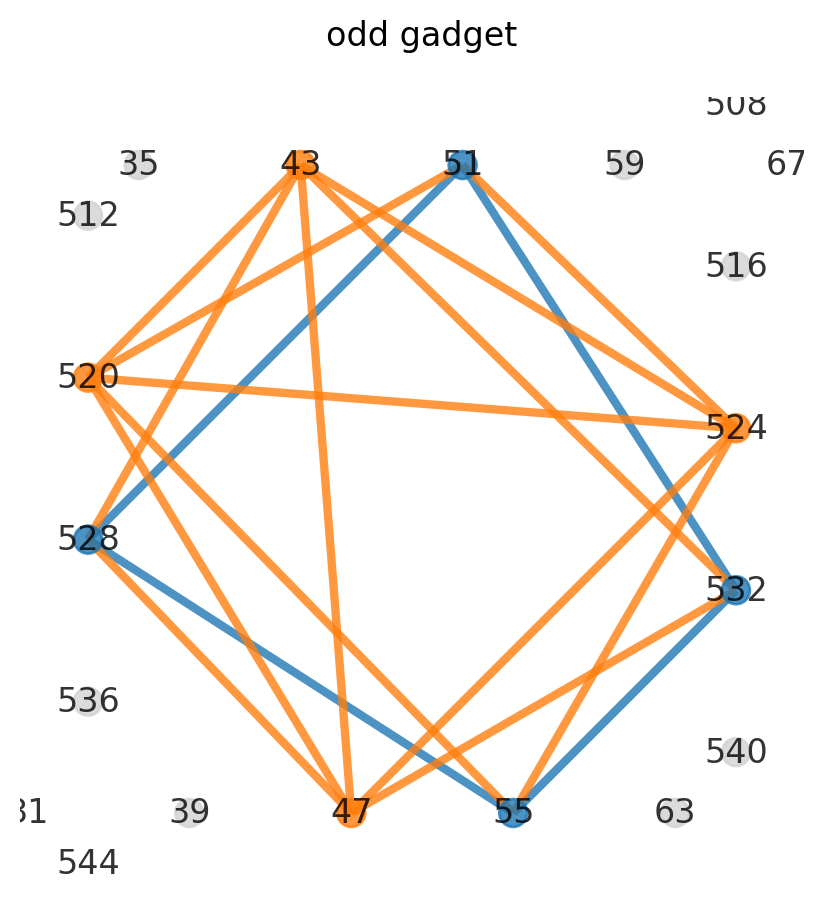

In [151]:
all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])
res = [key for key in h_dict.keys()]

G = dnx.zephyr_graph(4)
plt.ion()
plt.figure(figsize=(4,4))
plt.rcParams['figure.dpi'] = 400
plt.rcParams.update({'font.size':10})
plt.axis("off")
# plt.title("P=-1, odd embedding, sublatt A", x=0.5, y=1.2, fontsize = 20)
plt.title(odd_or_even + " gadget", x=0.5, y=1.2)

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent
# res_v2 = G.nodes()

node_colors = []
qubits_measure =  [520, 43, 47, 524] #majority rule
ancilla_list =  [51, 532, 55, 528]
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[1])
    elif site in ancilla_list:
        node_colors.append(all_colors[0])
    else:
        node_colors.append('#D3D3D3')


dnx.draw_zephyr(G, 
nodelist = res_v2, 
width = 3, node_size = 100, edgelist = edges_draw, with_labels = True, node_color = node_colors, alpha = 0.8, edge_color = edge_colors)

# numbering of states

In [70]:
sorted_qubits = np.array(sorted(list(h_dict.keys())))
print(sorted_qubits)
indices_measure = [np.where(sorted_qubits == qubits_measure[i])[0][0] for i in range(4)]
print(indices_measure)

def measure_parity(bitstring):
    return np.prod(bitstring[indices_measure])

def integer_identification(bitstring):
    val = 0
    for k in range(4):
        val += ((bitstring[indices_measure][k] + 1)/2)*2**(k)
    return int(val)


[ 43  47  51  55 520 524 528 532]
[4, 0, 1, 5]


In [69]:
for i in range(40):
    example_bitstring = 2*np.random.randint(0, 2, size = 8) - np.ones(8, dtype = int)
    print('bitstring', example_bitstring)
    print('parity', measure_parity(example_bitstring))
    print('label',integer_identification(example_bitstring))

bitstring [-1 -1  1 -1  1  1 -1  1]
parity 1
label 9
bitstring [-1  1  1 -1  1 -1 -1 -1]
parity 1
label 5
bitstring [-1  1 -1 -1  1 -1  1 -1]
parity 1
label 5
bitstring [ 1  1  1  1 -1  1 -1  1]
parity -1
label 14
bitstring [-1 -1  1 -1  1 -1 -1 -1]
parity -1
label 1
bitstring [ 1 -1 -1  1  1  1  1  1]
parity -1
label 11
bitstring [-1 -1  1  1 -1 -1  1  1]
parity 1
label 0
bitstring [-1 -1 -1 -1 -1  1 -1  1]
parity -1
label 8
bitstring [-1  1  1  1  1  1 -1  1]
parity -1
label 13
bitstring [-1 -1 -1 -1  1 -1 -1 -1]
parity -1
label 1
bitstring [ 1  1  1  1 -1  1 -1  1]
parity -1
label 14
bitstring [ 1 -1  1 -1  1 -1 -1  1]
parity 1
label 3
bitstring [ 1 -1 -1 -1  1  1  1  1]
parity -1
label 11
bitstring [-1  1 -1  1 -1  1  1  1]
parity 1
label 12
bitstring [-1 -1 -1  1  1 -1  1  1]
parity -1
label 1
bitstring [ 1  1 -1  1  1  1 -1 -1]
parity 1
label 15
bitstring [-1  1  1 -1 -1  1 -1 -1]
parity 1
label 12
bitstring [-1  1 -1  1 -1 -1 -1 -1]
parity -1
label 4
bitstring [-1 -1  1 -1 -1 -1

# time series for dynamics study

Here is how it works:

1. Perform a few forward annealing runs to obtain a good initial state that is the ground state (satisfies the constraint). 
2. Feed this as initial bitstring $S_0$, perform quick RA steps with $1 \mu s$ pause time at $s_p$ (different $s_p$ will have to be tested)
3. Analyze the time series. Assign a number $i \in 2^4$ to each uncovered bitstring, and whether it still satisfies the constraint (idea: numbers $i = 1, .. 8$ are *good* parity states, whicle $i = -1, .. -8$ are *wrong* parity states)   

In [152]:
#first, find a good initial state
num_reads = 200
anneal_time = 10
response_forward = sampler.sample_ising(h = h_dict, J=J_dict,
                                            num_reads=num_reads,
                                            annealing_time=anneal_time,
                                            answer_mode="raw", 
                                            num_spin_reversal_transforms = 10)
#dwave.inspector.show(response)


In [153]:
index_min_energy = np.argmin(response_forward.record.energy)
minimum_config = response_forward.record.sample[index_min_energy]
initial_bitstring = minimum_config

initial_bitstring = {}
for qubit in sampler.nodelist:
    if qubit in h_dict:
        index = np.where(sorted_qubits == qubit)[0][0]
        initial_bitstring.update({qubit : minimum_config[index]})
    else:
        initial_bitstring.update({qubit : 3})

print('initial state')
print('bitstring', minimum_config)
print('parity', measure_parity(minimum_config))
initial_parity = measure_parity(minimum_config)
print('label',integer_identification(minimum_config))

initial state
bitstring [ 1  1 -1 -1  1 -1 -1 -1]
parity -1
label 7


Then, you perform the time series

In [176]:
sp = 0.3
tp = 1
reverse_schedule = [[0.0, 1.0], [(1-sp), sp], [(1-sp) + tp, sp], [2*(1-sp) + tp, 1.0]]
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial_bitstring, reinitialize_state=False, answer_mode='raw', readout_thermalization = 10)
num_reads_series = 1000
reverse_answer = sampler.sample_ising(h_dict, J_dict, 
                                      num_reads=num_reads_series, 
                                      label='QEMC - ' + odd_or_even,
                                      **reverse_anneal_params)
reverse_solutions, reverse_energies = reverse_answer.record.sample, reverse_answer.record.energy

In [177]:
labels_of_solutions = []
parity_of_solutions = []
color_parity = []

for k in range(len(reverse_solutions)):
    labels_of_solutions.append(integer_identification(reverse_solutions[k]))
    parity = measure_parity(reverse_solutions[k])
    parity_of_solutions.append(parity)
    if parity == initial_parity:
        color_parity.append('green')
    else:
        color_parity.append('red')


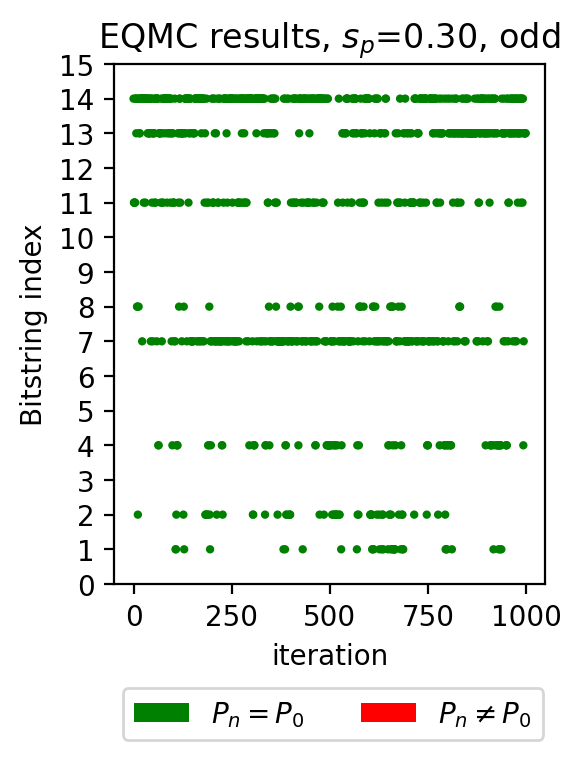

In [178]:
plt.ion()
fig, ax = subplots(figsize=(3,4))
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size':10})
plt.scatter(range(num_reads_series), labels_of_solutions, color = color_parity, s = 4)
plt.xlabel('iteration')
plt.ylabel('Bitstring index')
legend_elements = [Patch(facecolor='green', edgecolor='none',
                         label=r'$P_n = P_0$'), 
                    Patch(facecolor='red', edgecolor='none',
                         label=r'$P_n \neq P_0$')]

# Create the figure
#fig, ax = plt.subplots()
plt.legend(handles=legend_elements, bbox_to_anchor=(0.02, -0.2), loc='upper left', borderaxespad=0, ncol=2)
plt.title(r'EQMC results, $s_p$={:.2f}, '.format(sp) + odd_or_even )
ax.set_yticks(range(2**4));

save_label = 'EQMC results tp = {:.2f} sp={:.2f} '.format(tp, sp) + odd_or_even + '.png' 
plt.tight_layout()
plt.savefig('./figures/' + save_label)

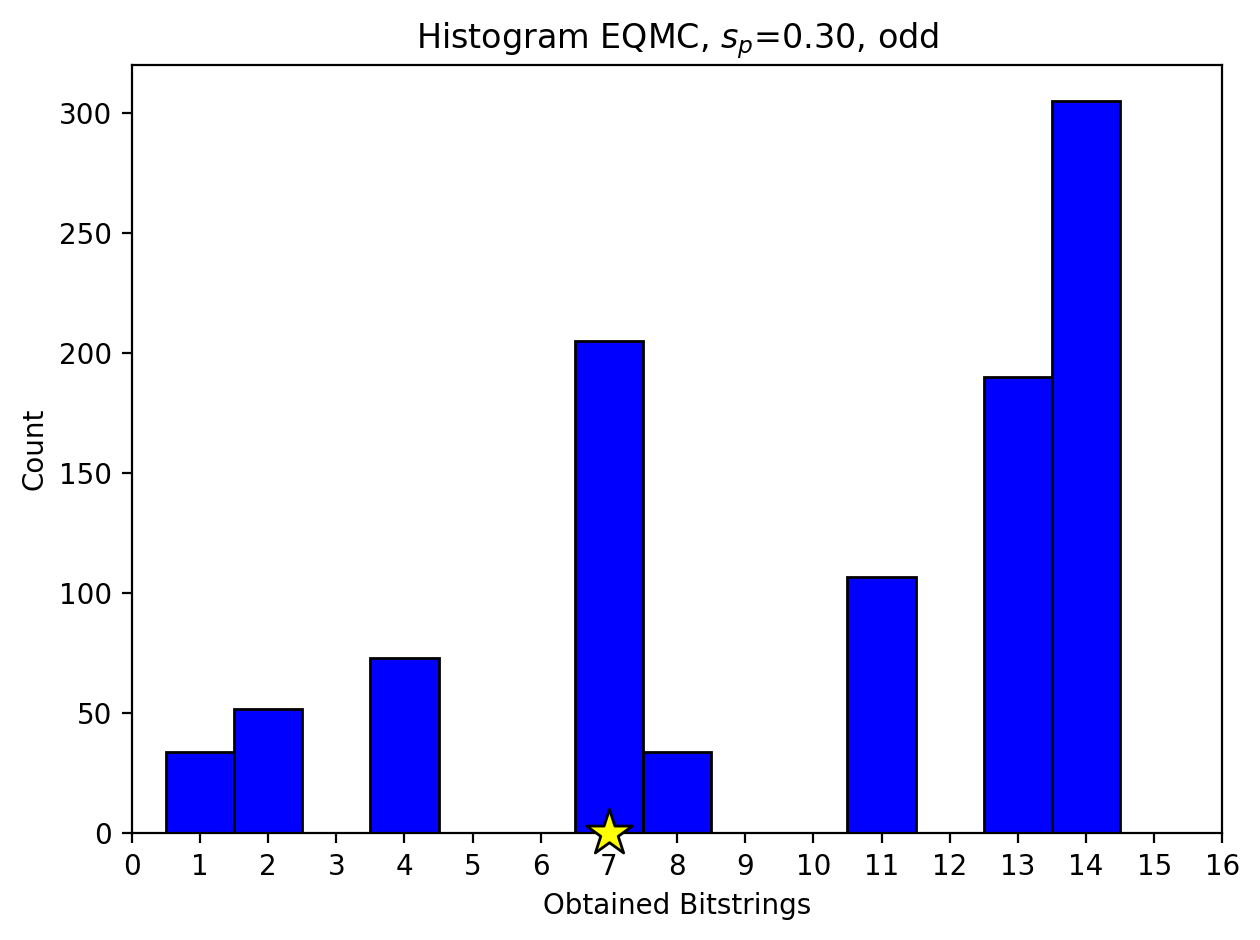

In [189]:
# Create histogram
bin_range = np.array(range(17)) - 0.5
plt.hist(labels_of_solutions, bins=bin_range, edgecolor='black', color = 'blue')

# Customize labels and title
plt.xlabel('Obtained Bitstrings')
plt.ylabel('Count')
plt.title(r'Histogram EQMC, $s_p$={:.2f}, '.format(sp) + odd_or_even )
plt.xlim([0, 16])
plt.xticks(range(17))
plt.scatter(integer_identification(minimum_config), 0, marker = '*', s = 300, color = 'yellow', edgecolor = 'black', zorder = 10, clip_on = False)
# Display the histogram

save_label = 'Histo tp = {:.2f} sp={:.2f} '.format(tp, sp) + odd_or_even + '.png' 
plt.tight_layout()
plt.savefig('./figures/' + save_label)

